In [1]:
"""
A simple user interface for XMem
"""

import os

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import cv2
import sys
import json

import numpy as np
from argparse import ArgumentParser

import shutil
import torch

import matplotlib.pyplot as plt
from easydict import EasyDict

from orion.utils.misc_utils import (
    load_first_frame_from_hdf5_dataset, 
    export_video_from_hdf5_dataset,
    load_first_frame_from_human_hdf5_dataset, 
    export_video_from_human_hdf5_dataset,
    overlay_xmem_mask_on_image,
    )
from orion.algos.grounded_sam_wrapper import GroundedSamWrapper


torch.set_grad_enabled(False)

wrapper = GroundedSamWrapper()



[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/yifengz/miniconda3/envs/dinov2/lib/python3.9/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


final text_encoder_type: bert-base-uncased
Model loaded from /home/yifengz/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [2]:
from PIL import Image
image = np.array(Image.open("example_image.png"))

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


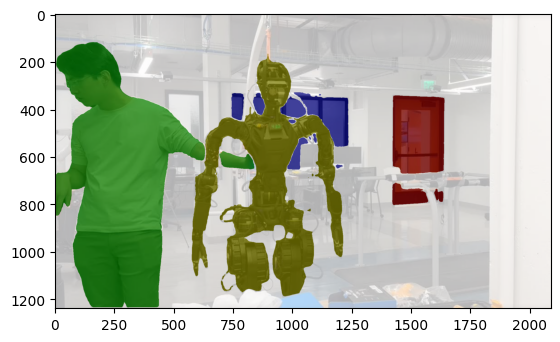

In [6]:
final_mask_image = wrapper.segment(image, ["a photo of a man", "a photo of humanoid robot", "a photo of door", "windows"])

overlay_image = overlay_xmem_mask_on_image(image, np.array(final_mask_image), use_white_bg=True, rgb_alpha=0.3)
plt.imshow(overlay_image)

In [4]:

args = EasyDict({
    "image": None,
    "video": None,
    "demo": None,
    "rollout": None,
    # "human_demo": "iphone_place_chip_bag_on_plate_1_demo.hdf5",
    # "text": ["chip bag", "plate"],
    # "human_demo": "iphone_pick_place_blue_mug_1_demo.hdf5",
    # "text": ["mug", "coaster"]
    # "human_demo": "iphone_front_boat/iphone_front_boat_demo.hdf5",
    # "text": ["small red block", "boat body"]
    # "human_demo": "long_horizon/long_horizon_rearrangement_cheese_4_demo.hdf5",
    # "text": ["chip bag", "plate", "coaster", "mug"]
    "human_demo": "long_horizon_boat/iphone_long_horizon_boat_18_demo.hdf5",
    "text": ["boat chimney", "red blocks", "red boat"]
    }
)

args.human_demo = os.path.join("datasets/iphones", args.human_demo)

def run():
    mode = ""
    if args.image is not None:
        mode = "image"
    elif args.video is not None:
        mode = "video"
    elif args.demo is not None:
        mode = "demo"
    elif args.human_demo is not None:
        mode = "human_demo"
    elif args.rollout is not None:
        mode = "rollout"

    annotation_folder = f"annotations/{mode}"
    tmp_folder = "tmp_images"

    if mode == "image":
        annotation_path = os.path.join(annotation_folder, args.image.split("/")[-1].split(".")[0])
    elif mode == "video":
        annotation_path = os.path.join(annotation_folder, args.video.split("/")[-1].split(".")[0])
    elif mode == "demo":
        annotation_path = os.path.join(annotation_folder, args.demo.split("/")[-1].split(".")[0])
    elif mode == "human_demo":
        annotation_path = os.path.join(annotation_folder, args.human_demo.split("/")[-1].split(".")[0])
    elif mode == "rollout":
        annotation_path = os.path.join(annotation_folder, args.rollout.split("/")[-1].split(".")[0])

    tmp_path = tmp_folder


    os.makedirs(annotation_path, exist_ok=True)
    os.makedirs(tmp_path, exist_ok=True)
    os.makedirs(os.path.join(tmp_path, "images"), exist_ok=True)

    if mode == "image":
        first_frame = cv2.imread(args.image)
    elif mode == "rollout":
        first_frame = cv2.imread(args.rollout)
    elif mode == "video":
        _, first_frame = cv2.VideoCapture(args.video).read()
    elif mode == "demo":
        first_frame = load_first_frame_from_hdf5_dataset(args.demo, demo_idx=args.demo_idx, bgr=True)
    elif mode == "human_demo":
        first_frame = load_first_frame_from_human_hdf5_dataset(args.human_demo, bgr=True)

    cv2.imwrite(os.path.join(os.path.join(tmp_path, "images", "frame.jpg")), first_frame)

    args.images = tmp_path
    args.workspace = tmp_path

    print(args.images, tmp_folder)

    # launch_gui(args)
    print("Annotating the image with text input: ", args.text)

    final_mask_image = wrapper.segment(first_frame, args.text)
    os.makedirs(os.path.join(tmp_path, "masks"), exist_ok=True)
    final_mask_image.save(os.path.join(tmp_path, "masks", "frame.png"))
    overlay_image = overlay_xmem_mask_on_image(first_frame, np.array(final_mask_image), use_white_bg=True, rgb_alpha=0.3)

    try:
        plt.imshow(overlay_image)
        plt.show()
    except:
        pass

    # copy a image from a folder to another
    shutil.copyfile(os.path.join(tmp_path, "images", "frame.jpg"), os.path.join(annotation_path, "frame.jpg"))
    shutil.copyfile(os.path.join(tmp_path, "masks", "frame.png"), os.path.join(annotation_path, "frame_annotation.png"))
    print("Annotation saved to ", os.path.join(annotation_path, "frame_annotation.png"))
    with open(os.path.join(annotation_path, "config.json"), "w") as f:
        config_dict = {"mode": mode}
        if mode == "image":
            config_dict["original_file"] = args.image
        elif mode == "rollout":
            config_dict["original_file"] = args.rollout            
        elif mode == "video":
            config_dict["original_file"] = args.video
            config_dict["video_file"] = args.video
        elif mode == "demo":
            config_dict["original_file"] = args.demo
            video_path = export_video_from_hdf5_dataset(
                            dataset_name=args.demo, 
                            demo_idx=args.demo_idx,
                            video_path=annotation_path,
                            video_name=args.demo.split("/")[-1].split(".")[0],
                            bgr=True)
            config_dict["video_file"] = video_path
        elif mode == "human_demo":
            config_dict["original_file"] = args.human_demo
            video_path = export_video_from_human_hdf5_dataset(
                            dataset_name=args.human_demo, 
                            video_path=annotation_path,
                            video_name=args.human_demo.split("/")[-1].split(".")[0],
                            bgr=True)
            config_dict["video_file"] = video_path
        config_dict["text"] = args.text
        json.dump(config_dict, f)
    # remove the folder
    shutil.rmtree(tmp_path)


run()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'datasets/iphones/long_horizon_boat/iphone_long_horizon_boat_18_demo.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)